<a href="https://www.kaggle.com/code/shedai/llm-attention-dersi?scriptVersionId=246896118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Attention Giriş

'makine öğrenmesi harika bir alan' cümlesi için Attention Mekanizması Analizi
1. Adım: Kelime Gömme (Word Embeddings) - Boyut: 12
  'makine': [0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97]
  'öğrenmesi': [0.83 0.21 0.18 0.18 0.3  0.52 0.43 0.29 0.61 0.14 0.29 0.37]
  'harika': [0.46 0.79 0.2  0.51 0.59 0.05 0.61 0.17 0.07 0.95 0.97 0.81]
  'bir': [0.3  0.1  0.68 0.44 0.12 0.5  0.03 0.91 0.26 0.66 0.31 0.52]
  'alan': [0.55 0.18 0.97 0.78 0.94 0.89 0.6  0.92 0.09 0.2  0.05 0.33]
------------------------------------------------------------
2. Adım: Q, K, V Vektörlerinin Hesaplanması - Boyut: 4
Örnek olarak ilk kelimenin ('makine') Q, K, V vektörleri:
  Q_1: [3.22 3.26 2.57 3.28]
  K_1: [3.46 2.9  3.82 3.16]
  V_1: [2.72 3.22 2.81 3.18]
------------------------------------------------------------
3. Adım: Ham Dikkat Skorları (Q @ K.T)
Her satır bir 'sorgu' kelimesini, her sütun bir 'anahtar' kelimesini temsil eder.
[[40.77 22.64 35.45 28.23 38.83]
 [28.93 16.33 25.67 20.11 

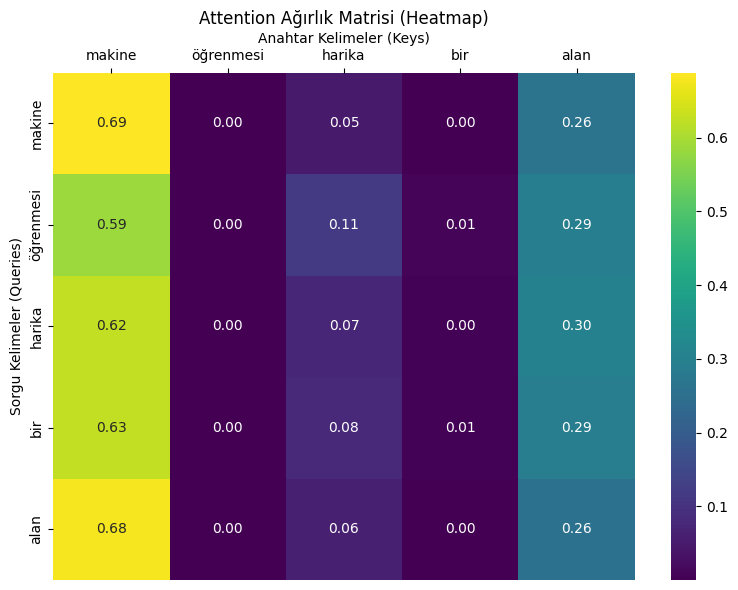

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def softmax(x):
    """Numerik olarak stabil bir softmax fonksiyonu."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def visualize_attention(sentence, attention_matrix):
    """Attention matrisini bir ısı haritası olarak görselleştirir."""
    
    # Türkçe karakterleri destekleyen bir font bulma denemesi
    try:
        # Örnek olarak yaygın bir font veya sisteminizde olan bir fontu deneyin
        # Linux için: "DejaVu Sans", Windows için: "Arial", macOS için: "Helvetica Neue"
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=12)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: Türkçe karakterler için 'DejaVu Sans' fontu bulunamadı. Etiketler düzgün görünmeyebilir.")
        print("Görselleştirmeyi iyileştirmek için sisteminizde var olan bir .ttf font dosyasının yolunu koda ekleyebilirsiniz.\n")


    tokens = sentence.split()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=ax)
    
    ax.set_title("Attention Ağırlık Matrisi (Heatmap)")
    ax.set_xlabel("Anahtar Kelimeler (Keys)")
    ax.set_ylabel("Sorgu Kelimeler (Queries)")
    ax.xaxis.tick_top()  # X ekseni etiketlerini üste taşı
    ax.xaxis.set_label_position('top')
    
    plt.tight_layout()
    plt.show()

def attention_step_by_step(sentence):
    """
    Verilen bir cümle için attention mekanizmasını adım adım çalıştırır ve görselleştirir.
    """
    print(f"'{sentence}' cümlesi için Attention Mekanizması Analizi")
    print("=" * 60)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. Adım: Model Parametreleri ve Gömme Vektörleri ---
    # Eğitim kolaylığı için boyutları küçük tutuyoruz.
    d_model = 12  # Her kelimenin temsil edildiği vektör boyutu (Embedding boyutu)
    d_k = 4       # Query ve Key vektörlerinin boyutu (d_v de aynı olacak)
    
    # Her çalıştırmada aynı sonuçları almak için rastgelelik tohumu
    np.random.seed(42) 
    
    # Her kelime için rastgele bir gömme vektörü oluşturalım.
    # Gerçekte bu vektörler bir embedding katmanından gelir.
    embeddings = np.random.rand(vocab_size, d_model)
    
    print(f"1. Adım: Kelime Gömme (Word Embeddings) - Boyut: {d_model}")
    for i, token in enumerate(tokens):
        print(f"  '{token}': {np.round(embeddings[i], 2)}")
    print("-" * 60)
        
    # --- 2. Adım: Ağırlık Matrisleri ve Q, K, V Hesaplanması ---
    # Bu matrisler normalde modelin eğitim sırasında öğrendiği ağırlıklardır.
    # Biz burada rastgele ama sabit matrisler kullanacağız.
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k) # d_v = d_k varsayalım
    
    # Her kelime için Q, K, V vektörlerini hesapla
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    print(f"2. Adım: Q, K, V Vektörlerinin Hesaplanması - Boyut: {d_k}")
    print("Örnek olarak ilk kelimenin ('{}') Q, K, V vektörleri:".format(tokens[0]))
    print(f"  Q_1: {np.round(Q[0], 2)}")
    print(f"  K_1: {np.round(K[0], 2)}")
    print(f"  V_1: {np.round(V[0], 2)}")
    print("-" * 60)
    
    # --- 3. Adım: Ham Dikkat Skorları ---
    # Her sorgunun (Q) her anahtarla (K) ne kadar ilişkili olduğunu ölçeriz.
    # Formül: scores = Q * K^T
    scores = Q @ K.T
    
    print("3. Adım: Ham Dikkat Skorları (Q @ K.T)")
    print("Her satır bir 'sorgu' kelimesini, her sütun bir 'anahtar' kelimesini temsil eder.")
    print(np.round(scores, 2))
    print("-" * 60)
    
    # --- 4. Adım: Ölçekleme ---
    # Gradyanların çok küçülmesini engellemek için skorları ölçekleriz.
    # Formül: scores / sqrt(d_k)
    scaled_scores = scores / np.sqrt(d_k)
    
    print(f"4. Adım: Ölçeklenmiş Skorlar (Skorlar / sqrt({d_k}))")
    print(np.round(scaled_scores, 2))
    print("-" * 60)
    
    # --- 5. Adım: Softmax ---
    # Ölçeklenmiş skorları [0, 1] aralığında bir olasılık dağılımına dönüştürürüz.
    # Her satırın toplamı 1 olur. Bu bizim ATTENTION matrisimizdir.
    attention_weights = softmax(scaled_scores)
    
    print("5. Adım: Softmax ile Ağırlıkların Hesaplanması (Attention Matrisi)")
    print("Her kelimenin diğer kelimelere ne kadar 'dikkat' edeceğini gösterir.")
    print(np.round(attention_weights, 2))
    print("-" * 60)
    
    # --- 6. Adım: Sonuç Vektörlerinin Hesaplanması ---
    # Her kelime için nihai çıktı, dikkat ağırlıkları ile Değer (V) vektörlerinin
    # ağırlıklı toplamıdır.
    # Formül: output = attention_weights * V
    output = attention_weights @ V
    
    print("6. Adım: Nihai Çıktı Vektörleri (Attention_Weights @ V)")
    print("Her kelimenin yeni vektörü, cümlenin bağlam bilgisini içerir.")
    for i, token in enumerate(tokens):
        print(f"  '{token}' için yeni vektör: {np.round(output[i], 2)}")
    print("-" * 60)
    
    # --- 7. Adım: Görselleştirme ---
    print("7. Adım: Attention Matrisinin Görselleştirilmesi")
    visualize_attention(sentence, attention_weights)
    

if __name__ == '__main__':
    # Analiz edilecek örnek cümle
    ornek_cumle = "makine öğrenmesi harika bir alan"
    attention_step_by_step(ornek_cumle)

# 2. Sparse Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri işlerken zorlanır' cümlesi için Full vs. Sparse Attention Analizi
Sparse Attention Pencere Boyutu: 1 (her kelime sağına ve soluna 1 kelimeye bakar)
1-4. Adımlar: Gömme, Q,K,V, Skor ve Ölçekleme işlemleri her iki yöntem için de ortaktır.
Ölçeklenmiş Skor Matrisi:
[[19.   12.66 18.05 14.02 19.24 16.08 15.45]
 [12.83  8.65 12.31  9.56 13.27 10.98 10.42]
 [16.39 11.06 15.57 12.08 16.62 13.87 13.39]
 [15.85 10.61 15.09 11.73 16.12 13.46 12.88]
 [18.89 12.63 17.97 13.92 19.22 15.98 15.39]
 [18.56 12.44 17.67 13.72 18.88 15.74 15.11]
 [15.62 10.41 14.86 11.54 15.86 13.24 12.69]]
--------------------------------------------------------------------------------
a) Full Attention Ağırlıkları (Softmax uygulanmış hali)
[[0.36 0.   0.14 0.   0.46 0.02 0.01]
 [0.29 0.   0.17 0.01 0.45 0.05 0.03]
 [0.35 0.   0.15 0.   0.44 0.03 0.02]
 [0.34 0.   0.16 0.01 0.45 0.03 0.02]
 [0.35 0.   0.14 0.   0.48 0.02 0.01]
 [0.35 0.   0.14 0.   0.48 0.02 0.01]
 [0.34 0.   0.16 0.

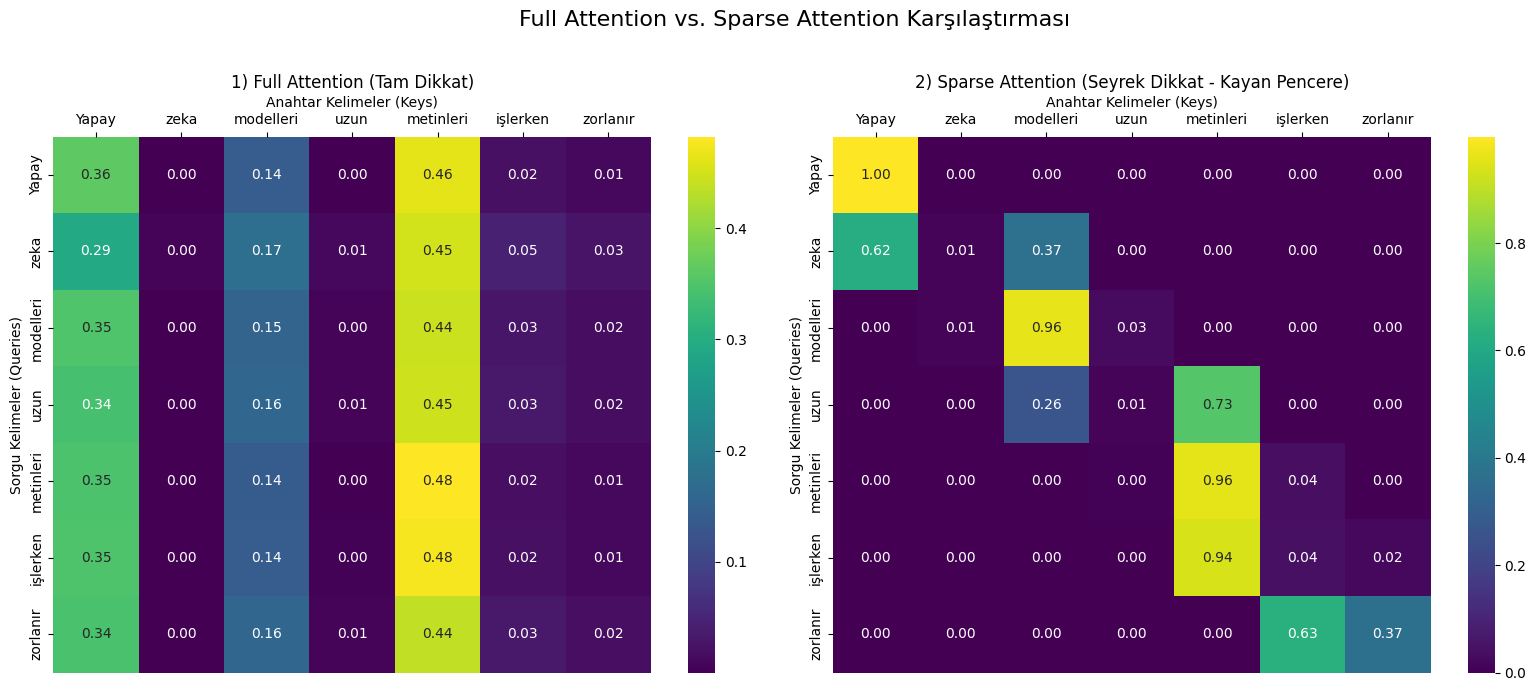

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Bir önceki koddan alınan yardımcı fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# YENİ KARŞILAŞTIRMA GÖRSELLEŞTİRME FONKSİYONU
def visualize_attention_comparison(sentence, full_attention_matrix, sparse_attention_matrix):
    """Full ve Sparse Attention matrislerini yan yana görselleştirir."""
    
    # Türkçe karakter desteği için font ayarı
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=10)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.\n")
    
    tokens = sentence.split()
    
    # İki grafiği yan yana çizmek için bir figure ve subplotlar oluştur
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Sol Grafik: Full Attention
    sns.heatmap(full_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
    axes[0].set_title("1) Full Attention (Tam Dikkat)")
    axes[0].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[0].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[0].xaxis.tick_top()
    axes[0].xaxis.set_label_position('top')
    
    # Sağ Grafik: Sparse Attention
    sns.heatmap(sparse_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[1])
    axes[1].set_title("2) Sparse Attention (Seyrek Dikkat - Kayan Pencere)")
    axes[1].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[1].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[1].xaxis.tick_top()
    axes[1].xaxis.set_label_position('top')
    
    fig.suptitle("Full Attention vs. Sparse Attention Karşılaştırması", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# YENİ MASKE OLUŞTURMA FONKSİYONU
def create_sliding_window_mask(sequence_length, window_size):
    """
    Kayan pencere (sliding window) sparse attention için bir maske oluşturur.
    Pencere dışındaki pozisyonlara -infinity değeri atanır.
    """
    mask = np.zeros((sequence_length, sequence_length))
    for i in range(sequence_length):
        for j in range(sequence_length):
            # Eğer j pozisyonu, i'nin penceresi dışındaysa, maskele
            if abs(i - j) > window_size:
                mask[i, j] = -np.inf
    return mask

def attention_comparison_step_by_step(sentence, window_size=1):
    """
    Full ve Sparse Attention mekanizmalarını karşılaştırır.
    """
    print(f"'{sentence}' cümlesi için Full vs. Sparse Attention Analizi")
    print(f"Sparse Attention Pencere Boyutu: {window_size} (her kelime sağına ve soluna {window_size} kelimeye bakar)")
    print("=" * 80)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. ve 2. Adımlar (Ortak) ---
    d_model = 12
    d_k = 4
    np.random.seed(42) 
    
    embeddings = np.random.rand(vocab_size, d_model)
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k)
    
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    # --- 3. ve 4. Adımlar (Ortak) ---
    scores = Q @ K.T
    scaled_scores = scores / np.sqrt(d_k)
    
    print("1-4. Adımlar: Gömme, Q,K,V, Skor ve Ölçekleme işlemleri her iki yöntem için de ortaktır.")
    print("Ölçeklenmiş Skor Matrisi:")
    print(np.round(scaled_scores, 2))
    print("-" * 80)
    
    # --- FULL ATTENTION HESAPLAMASI ---
    full_attention_weights = softmax(scaled_scores)
    print("a) Full Attention Ağırlıkları (Softmax uygulanmış hali)")
    print(np.round(full_attention_weights, 2))
    print("-" * 80)

    # --- SPARSE ATTENTION HESAPLAMASI ---
    
    # 5. Adım: Seyreltme Maskesi Oluşturma (YENİ ADIM)
    print("b) Sparse Attention için adımlar:")
    print("5. Adım: Kayan Pencere Maskesi Oluşturma")
    print("Pencere dışındaki konumlara -inf değeri atanır, böylece softmax sonrası skorları 0 olur.")
    mask = create_sliding_window_mask(vocab_size, window_size)
    print(mask)
    print("-" * 80)
    
    # 6. Adım: Maskeyi Uygulama (YENİ ADIM)
    print("6. Adım: Maskenin Ölçeklenmiş Skorlara Uygulanması")
    masked_scores = scaled_scores + mask
    print("Maske uygulandıktan sonraki skorlar (softmax öncesi):")
    print(np.round(masked_scores, 2))
    print("-" * 80)
    
    # 7. Adım: Maskeli Skorlara Softmax Uygulama
    sparse_attention_weights = softmax(masked_scores)
    print("7. Adım: Sparse Attention Ağırlıkları (Maskeli skorlara Softmax uygulanmış hali)")
    print("Dikkat'in sadece komşu kelimelere odaklandığına dikkat edin.")
    print(np.round(sparse_attention_weights, 2))
    print("-" * 80)
    
    # --- 8. Adım: Karşılaştırmalı Görselleştirme ---
    print("8. Adım: Sonuçların Karşılaştırılması")
    print("İki dikkat matrisi şimdi görselleştirilecek...")
    visualize_attention_comparison(sentence, full_attention_weights, sparse_attention_weights)

if __name__ == '__main__':
    # Sparse attention etkisini daha iyi görmek için biraz daha uzun bir cümle
    ornek_cumle = "Yapay zeka modelleri uzun metinleri işlerken zorlanır"
    
    # Pencere boyutu: Her kelime, sağındaki ve solundaki 1 kelimeye dikkat eder.
    # Bu değeri 2 veya 3 yaparak pencereyi genişletebilirsiniz.
    pencere_boyutu = 1
    
    attention_comparison_step_by_step(ornek_cumle, window_size=pencere_boyutu)

# 3. Big Birds Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri işlerken hesaplama maliyeti nedeniyle zorlanır' cümlesi için Attention Mekanizmaları Analizi
BigBird Parametreleri -> Pencere: 2, Rastgele: 2, Genel: [0]
BigBird Maskesi Oluşturuluyor...
Analiz tamamlandı. Karşılaştırma grafiği oluşturuluyor...

Uyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.



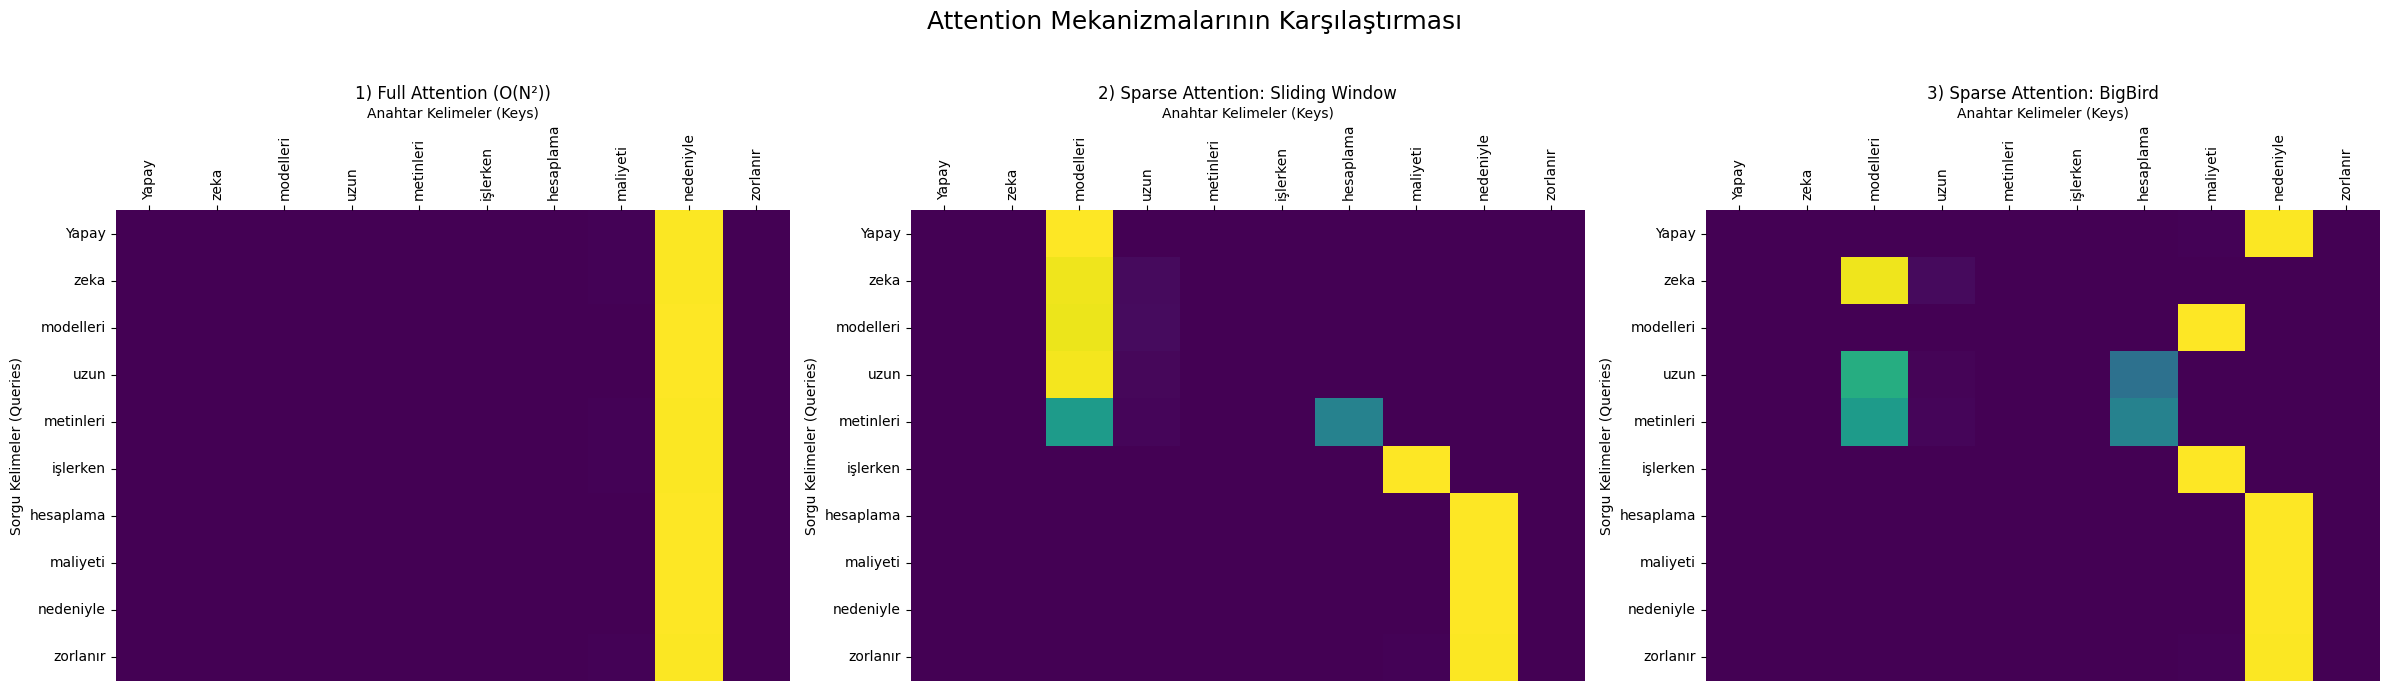

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Önceki kodlardan alınan yardımcı fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# --- BigBird için yeni maske oluşturma fonksiyonları ---

def create_sliding_window_mask(sequence_length, window_size):
    """Kayan pencere için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        start = max(0, i - window_size)
        end = min(sequence_length, i + window_size + 1)
        mask[i, start:end] = 0
    return mask

def create_random_mask(sequence_length, num_random_tokens, window_size):
    """Rastgele dikkat için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        # Rastgele indisleri seç
        random_indices = np.random.choice(sequence_length, num_random_tokens, replace=False)
        mask[i, random_indices] = 0
    return mask

def create_global_mask(sequence_length, global_indices):
    """Genel dikkat için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    # Global token'ların olduğu satır ve sütunları tamamen aç
    mask[global_indices, :] = 0
    mask[:, global_indices] = 0
    return mask

# --- YENİ 3'LÜ KARŞILAŞTIRMA GÖRSELLEŞTİRME FONKSİYONU ---
def visualize_bigbird_comparison(sentence, full_att, window_att, bigbird_att):
    """Üç dikkat matrisini yan yana görselleştirir."""
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=9)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.\n")
    
    tokens = sentence.split()
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Grafik 1: Full Attention
    sns.heatmap(full_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[0], cbar=False)
    axes[0].set_title("1) Full Attention (O(N²))")
    
    # Grafik 2: Sliding Window Attention
    sns.heatmap(window_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[1], cbar=False)
    axes[1].set_title("2) Sparse Attention: Sliding Window")

    # Grafik 3: BigBird Attention
    sns.heatmap(bigbird_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[2], cbar=False)
    axes[2].set_title("3) Sparse Attention: BigBird")

    for ax in axes:
        ax.set_xlabel("Anahtar Kelimeler (Keys)")
        ax.set_ylabel("Sorgu Kelimeler (Queries)")
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.setp(ax.get_xticklabels(), rotation=90)


    fig.suptitle("Attention Mekanizmalarının Karşılaştırması", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def bigbird_attention_demo(sentence, window_size=1, num_random_tokens=1, global_indices=[0]):
    """
    Full, Sliding Window ve BigBird Attention mekanizmalarını karşılaştırır.
    """
    print(f"'{sentence}' cümlesi için Attention Mekanizmaları Analizi")
    print(f"BigBird Parametreleri -> Pencere: {window_size}, Rastgele: {num_random_tokens}, Genel: {global_indices}")
    print("=" * 80)
    
    tokens = sentence.split()
    seq_len = len(tokens)
    
    # Adım 1-4: Ortak Hesaplamalar
    d_model, d_k = 32, 8
    np.random.seed(42)
    embeddings = np.random.rand(seq_len, d_model)
    W_q, W_k, W_v = [np.random.rand(d_model, d_k) for _ in range(3)]
    Q, K, V = embeddings @ W_q, embeddings @ W_k, embeddings @ W_v
    scaled_scores = (Q @ K.T) / np.sqrt(d_k)
    
    # 1. YOL: FULL ATTENTION
    full_attention_weights = softmax(scaled_scores)
    
    # 2. YOL: SLIDING WINDOW ATTENTION
    window_mask = create_sliding_window_mask(seq_len, window_size)
    window_attention_weights = softmax(scaled_scores + window_mask)
    
    # 3. YOL: BIGBIRD ATTENTION
    print("BigBird Maskesi Oluşturuluyor...")
    # Üç farklı maskeyi oluştur
    mask1_window = create_sliding_window_mask(seq_len, window_size)
    mask2_random = create_random_mask(seq_len, num_random_tokens, window_size)
    mask3_global = create_global_mask(seq_len, global_indices)
    
    # Maskeleri birleştir. Bir pozisyona herhangi bir maske izin veriyorsa (0 ise),
    # o pozisyon açık kalmalıdır.
    bigbird_mask = np.maximum.reduce([mask1_window, mask2_random, mask3_global])
    
    # BigBird ağırlıklarını hesapla
    bigbird_attention_weights = softmax(scaled_scores + bigbird_mask)
    
    print("Analiz tamamlandı. Karşılaştırma grafiği oluşturuluyor...")
    
    # Sonuçları görselleştir
    visualize_bigbird_comparison(sentence, full_attention_weights, window_attention_weights, bigbird_attention_weights)


if __name__ == '__main__':
    ornek_cumle = "Yapay zeka modelleri uzun metinleri işlerken hesaplama maliyeti nedeniyle zorlanır"
    
    # BigBird Parametreleri
    pencere_boyutu = 2       # Her kelime sağına/soluna 2 kelimeye bakar
    rastgele_token_sayisi = 2 # Her kelime rastgele 2 kelimeye daha bakar
    genel_token_indisleri = [0] # İlk kelime ('Yapay') genel token'dır
    
    bigbird_attention_demo(ornek_cumle, pencere_boyutu, rastgele_token_sayisi, genel_token_indisleri)

# 4. Flash Attention

In [5]:
import numpy as np

def naive_attention(Q, K, V):
    """Standart, basit ve verimsiz attention hesaplaması."""
    print("--- 1) Naif (Standart) Attention Hesaplanıyor ---")
    d_k = Q.shape[-1]
    
    # Tüm matrisler üzerinde tek seferde işlem yapılır
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights /= np.sum(weights, axis=-1, keepdims=True)
    output = weights @ V
    
    print("Naif Attention tamamlandı. Sonuç hafızada.\n")
    return output

def flash_attention_detailed_steps(Q, K, V, block_size):
    """
    FlashAttention'ın mantığını, ara adımları detaylı bir şekilde basarak simüle eder.
    BU BİR PERFORMANS OPTİMİZASYONU DEĞİL, KAVRAMSAL BİR SİMÜLASYONDUR.
    """
    print(f"--- 2) FlashAttention (Detaylı Adımlar) Hesaplanıyor (Blok Boyutu: {block_size}) ---")
    
    seq_len, d_k = Q.shape
    output = np.zeros_like(Q)
    
    num_blocks = seq_len // block_size
    
    # Sadece ilk satırın (ilk kelimenin) evrimini takip edeceğiz
    trace_row_index = 0

    # Q matrisini bloklara ayır (Dış Döngü)
    for i in range(num_blocks):
        start_i, end_i = i * block_size, (i + 1) * block_size
        Q_block = Q[start_i:end_i, :]
        
        # Bu Q bloğu için çıktı ve istatistikleri başlat
        O_block = np.zeros_like(Q_block)
        l_block = np.zeros(block_size)
        m_block = np.full(block_size, -np.inf)
        
        print(f"\n[Dış Döngü] Q'nun {i+1}. bloğu işleniyor (Satır {start_i}-{end_i-1})...")
        if start_i <= trace_row_index < end_i:
            print(f"  Takip edilen satır ({trace_row_index}) için başlangıç durumu:")
            print(f"    m (max skor) = {m_block[trace_row_index - start_i]:.2f}, l (norm. faktör) = {l_block[trace_row_index - start_i]:.2f}")
            print(f"    O (çıktı)    = {np.round(O_block[trace_row_index - start_i], 2)}")

        # K ve V matrislerini bloklara ayır (İç Döngü)
        for j in range(num_blocks):
            start_j, end_j = j * block_size, (j + 1) * block_size
            K_block = K[start_j:end_j, :]
            V_block = V[start_j:end_j, :]
            
            # --- SRAM İÇİNDEKİ HESAPLAMALAR ---
            S_ij = (Q_block @ K_block.T) / np.sqrt(d_k)
            
            # Online Softmax güncellemesi
            m_old = m_block
            l_old = l_block
            O_old = np.copy(O_block) # Karşılaştırma için kopyala
            
            m_new = np.maximum(m_old, np.max(S_ij, axis=1))
            P_ij = np.exp(S_ij - m_new[:, np.newaxis])
            exp_m_diff = np.exp(m_old - m_new)
            
            l_new = exp_m_diff * l_old + np.sum(P_ij, axis=1)
            
            # O vektörünü güncelle: Eski değeri yeniden ölçeklendir ve yeni değeri ekle
            O_block = O_old * exp_m_diff[:, np.newaxis]
            O_block += (P_ij @ V_block)
            
            # Bir sonraki döngü için m ve l'yi güncelle
            m_block = m_new
            l_block = l_new
            
            if start_i <= trace_row_index < end_i:
                print(f"  [İç Döngü] K/V'nin {j+1}. bloğu işlendi:")
                print(f"    m güncellendi: {m_old[trace_row_index - start_i]:.2f} -> {m_new[trace_row_index - start_i]:.2f}")
                print(f"    l güncellendi: {l_old[trace_row_index - start_i]:.2f} -> {l_new[trace_row_index - start_i]:.2f}")
                print(f"    O güncellendi: {np.round(O_old[trace_row_index - start_i, :4], 2)} -> {np.round(O_block[trace_row_index - start_i, :4], 2)}")

        # Bu Q bloğu için tüm hesaplamalar bitti, nihai sonucu HBM'e yaz
        output[start_i:end_i, :] = O_block / l_block[:, np.newaxis]

    print("\nTüm bloklar işlendi. FlashAttention tamamlandı.\n")
    return output

if __name__ == '__main__':
    # Parametreler
    SEQUENCE_LENGTH = 128 
    D_MODEL = 64
    BLOCK_SIZE = 32 

    # Rastgele Q, K, V matrisleri oluştur
    np.random.seed(42)
    Q = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    K = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    V = np.random.randn(SEQUENCE_LENGTH, D_MODEL)

    # 1. Yöntem: Standart Yaklaşım (Referans sonuç)
    output_naive = naive_attention(Q, K, V)
    
    # 2. Yöntem: FlashAttention Adım Adım Simülasyonu
    output_flash = flash_attention_detailed_steps(Q, K, V, BLOCK_SIZE)
    
    # 3. Sonuçları Karşılaştırma
    print("--- 3) Sonuçların Karşılaştırılması ---")
    are_same = np.allclose(output_naive, output_flash, atol=1e-6)
    
    print(f"Naif Attention ve FlashAttention sonuçları matematiksel olarak aynı mı? -> {are_same}")
    if are_same:
        print("Kanıt: Adım adım ilerleyen 'online' güncelleme mekanizması, tek seferde yapılan hesaplama ile aynı sonucu vermiştir.")
    else:
        print("Hata: Sonuçlar farklı, simülasyonda bir sorun var.")

    print("\nNihai Çıktı Karşılaştırması (ilk satır):")
    print("Naif  :", np.round(output_naive[0, :5], 4))
    print("Flash :", np.round(output_flash[0, :5], 4))

--- 1) Naif (Standart) Attention Hesaplanıyor ---
Naif Attention tamamlandı. Sonuç hafızada.

--- 2) FlashAttention (Detaylı Adımlar) Hesaplanıyor (Blok Boyutu: 32) ---

[Dış Döngü] Q'nun 1. bloğu işleniyor (Satır 0-31)...
  Takip edilen satır (0) için başlangıç durumu:
    m (max skor) = -inf, l (norm. faktör) = 0.00
    O (çıktı)    = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [İç Döngü] K/V'nin 1. bloğu işlendi:
    m güncellendi: -inf -> 1.69
    l güncellendi: 0.00 -> 7.83
    O güncellendi: [0. 0. 0. 0.] -> [-4.61  2.12  0.68 -0.24]
  [İç Döngü] K/V'nin 2. bloğu işlendi:
    m güncellendi: 1.69 -> 1.69
    l güncellendi: 7.83 -> 15.34
    O güncellendi: [-4.61  2.12  0.68 -0.24] -> [-2.96  3.25 -1.54 -1.71]
  [İç Döngü] K/V'nin 3. bloğu işlendi:
    m güncellendi: 1.69 -> 2.01
    l güncellendi: 15.34 -> 17.04
    O güncellendi

# 5. Mixture of Experts (MoE) Uzmanlar Karması

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Adım: Uzman (Expert) Modülünü Tanımlama
# Her bir uzman, basit bir Feed-Forward Network (FFN) olacak.
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Basit bir iki katmanlı ağ: Linear -> ReLU -> Linear
        hidden = F.relu(self.fc1(x))
        output = self.fc2(hidden)
        return output

# 2. Adım: Yönlendirici (Gating Network) Modülünü Tanımlama
# Bu ağ, hangi uzmanın hangi token için ne kadar uygun olduğuna karar verir.
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        # Çıktısı, uzman sayısı kadar olan basit bir lineer katman
        self.layer = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Girdiyi alır ve her uzman için bir "puan" (logit) üretir.
        logits = self.layer(x)
        return logits

# 3. Adım: MoE Katmanını Bir Araya Getirme
class MoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k

        # Uzmanları bir liste içinde oluştur
        # nn.ModuleList, PyTorch'un bu uzmanları modelin bir parçası olarak görmesini sağlar.
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])
        
        # Yönlendirici ağı oluştur
        self.gating_network = GatingNetwork(input_dim, num_experts)
        print(f"{num_experts} uzmanlı ve top_k={top_k} olacak şekilde bir MoE katmanı oluşturuldu.")

    def forward(self, x):
        # x'in şekli: (batch_size, sequence_len, input_dim)
        # Eğitim kolaylığı için batch_size=1 ve sequence_len=token sayısı varsayalım.
        # x'in şekli: (num_tokens, input_dim)
        num_tokens, input_dim = x.shape

        # Adım A: Yönlendiriciden her token için uzman puanlarını al
        # gating_logits şekli: (num_tokens, num_experts)
        gating_logits = self.gating_network(x)
        
        # Adım B: Her token için en iyi k uzmanı ve onların puanlarını seç
        # torch.topk, hem değerleri (puanları) hem de indisleri döndürür.
        top_k_logits, top_k_indices = torch.topk(gating_logits, self.top_k, dim=-1)
        
        # Adım C: Seçilen k uzmanın puanlarına softmax uygulayarak ağırlıklar elde et
        # Bu ağırlıkların toplamı her token için 1 olur.
        top_k_weights = F.softmax(top_k_logits, dim=-1)

        # Adım D: Çıktıyı hesapla
        final_output = torch.zeros_like(x)

        # Her bir token için adım adım işlem yapalım (anlaşılırlık için döngü kullanıyoruz)
        print("\n--- Token Bazında Uzman Seçimi ve Hesaplama ---")
        for i in range(num_tokens):
            print(f"\nToken {i+1} için analiz:")
            print(f"  Tüm uzmanlar için ham puanlar (logits): {np.round(gating_logits[i].detach().numpy(), 2)}")
            print(f"  Seçilen en iyi {self.top_k} uzman (indisler): {top_k_indices[i].tolist()}")
            print(f"  Bu uzmanların ağırlıkları (softmax sonrası): {np.round(top_k_weights[i].detach().numpy(), 2)}")

            token_output = torch.zeros(input_dim)
            
            # Seçilen k uzmanı döngüye al
            for j in range(self.top_k):
                expert_index = top_k_indices[i, j].item()
                expert_weight = top_k_weights[i, j]
                
                # İlgili uzmandan çıktıyı al
                expert_output = self.experts[expert_index](x[i])
                
                # Ağırlıklı çıktıyı topla
                token_output += expert_weight * expert_output

                print(f"    -> Uzman {expert_index} çalıştı. Ağırlık: {expert_weight:.2f}")

            final_output[i] = token_output
        
        return final_output

if __name__ == '__main__':
    # Simülasyon için parametreler
    # Genellikle bir cümlenin embedding vektörlerinin boyutu
    input_dim = 32    
    # Her uzmanın içindeki gizli katman boyutu
    hidden_dim = 64   
    # Çıktı boyutu (girdi ile aynı)
    output_dim = 32   
    # Toplam uzman sayısı
    num_experts = 8   
    # Her token için seçilecek en iyi uzman sayısı
    top_k = 2         

    # Modeli oluştur
    moe_layer = MoELayer(input_dim, hidden_dim, output_dim, num_experts, top_k)

    # 4 farklı token'dan oluşan sahte bir girdi oluşturalım
    # (Örn: "Yapay zeka harikadır" cümlesinin token vektörleri)
    num_tokens = 4
    input_tokens = torch.randn(num_tokens, input_dim)

    # Modeli çalıştır ve çıktıyı al
    final_output = moe_layer(input_tokens)

    print("\n--- Nihai Sonuç ---")
    print(f"MoE katmanından geçen {num_tokens} token'ın nihai çıktı vektörleri:")
    # Çıktının sadece ilk 5 boyutunu gösterelim
    print(np.round(final_output[:, :5].detach().numpy(), 3))

8 uzmanlı ve top_k=2 olacak şekilde bir MoE katmanı oluşturuldu.

--- Token Bazında Uzman Seçimi ve Hesaplama ---

Token 1 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [ 0.35  0.28 -0.34  0.32  0.73  0.27  0.26  0.16]
  Seçilen en iyi 2 uzman (indisler): [4, 0]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.59 0.41]
    -> Uzman 4 çalıştı. Ağırlık: 0.59
    -> Uzman 0 çalıştı. Ağırlık: 0.41

Token 2 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [ 0.23 -0.11  0.58 -1.52 -0.73 -0.72  0.61 -0.36]
  Seçilen en iyi 2 uzman (indisler): [6, 2]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.51 0.49]
    -> Uzman 6 çalıştı. Ağırlık: 0.51
    -> Uzman 2 çalıştı. Ağırlık: 0.49

Token 3 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [ 1.27  0.62  0.18 -0.05 -1.14 -0.45 -0.45 -0.29]
  Seçilen en iyi 2 uzman (indisler): [0, 1]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.66 0.34]
    -> Uzman 0 çalıştı. Ağırlık: 0.66
    -> Uzman 1 çalıştı. Ağırlık: 0.34

Token 

# 6. Uçtan Uca Örnek (QnA)

               UÇTAN UCA SORU-CEVAP MODELİ SİMÜLASYONU

--- Adım 1: Girdileri Vektörlere Dönüştürme (Embedding) ---
Bağlam 'Türkiye'nin başkenti Ankara şehridir ve 1923 yılında başkent olmuştur.' torch.Size([1, 9, 32]) boyutlu bir tensöre dönüştürüldü.
Soru 'Ankara ne zaman başkent oldu?' torch.Size([1, 5, 32]) boyutlu bir tensöre dönüştürüldü.


============================== ENCODER AŞAMASI ==============================
Amaç: Bağlam cümlesinin zengin bir anlamsal temsilini oluşturmak.


--- Adım 2: Self-Attention (Öz-Dikkat) ---
Encoder, bağlamdaki her kelimenin diğer kelimelerle ilişkisini tartar.


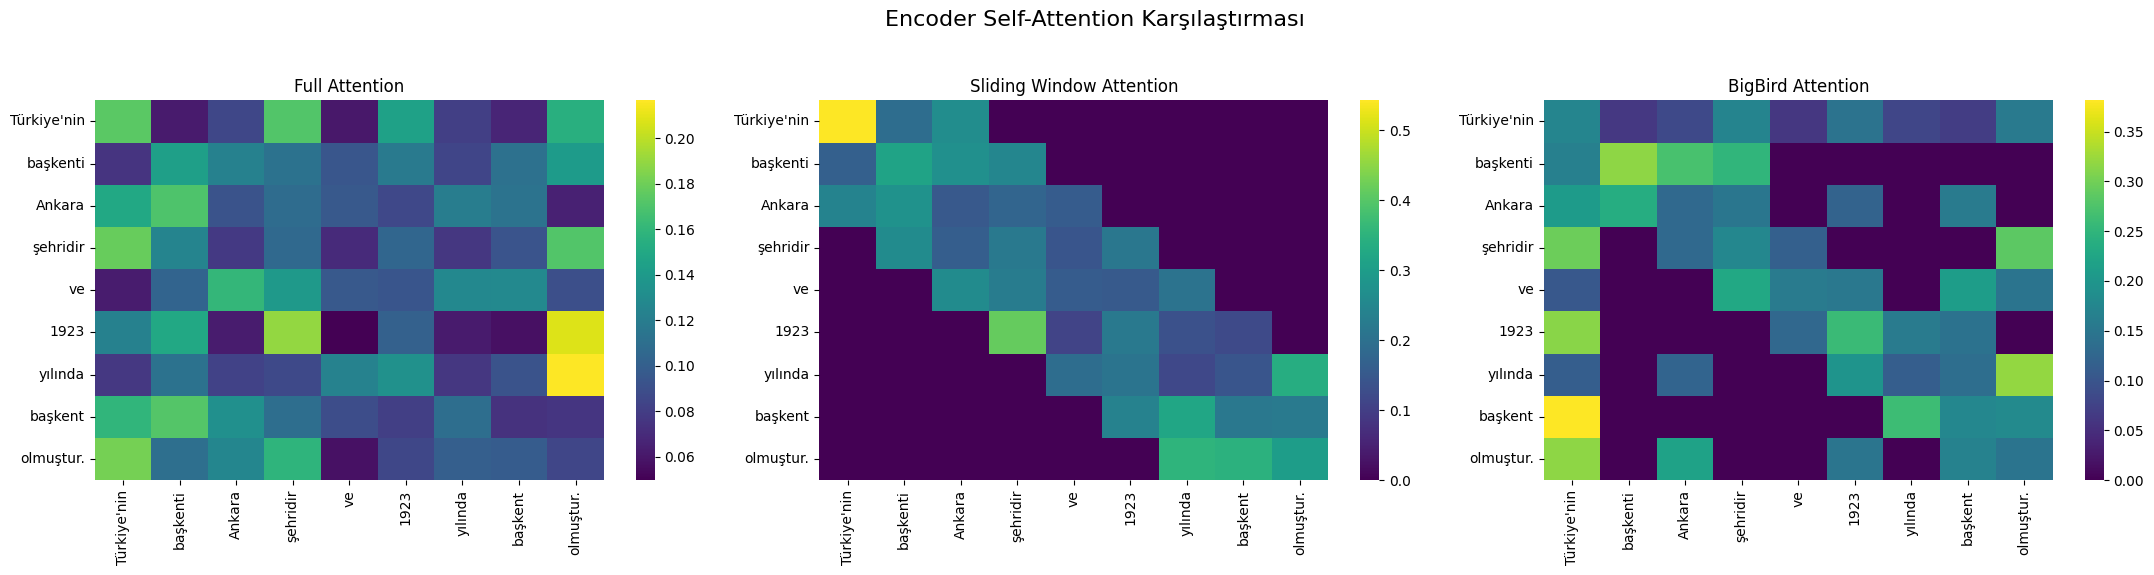


>>> FlashAttention Notu: Yukarıdaki dikkat matrislerinden herhangi biri, hesaplama sırasında
    GPU'nun yavaş HBM'i yerine hızlı SRAM'ini kullanan FlashAttention algoritması ile
    çok daha hızlı bir şekilde (sonuç değişmeden) hesaplanabilir.

Simülasyonun devamı için BigBird Attention çıktısı seçildi.

--- Adım 3: Feed-Forward Network (FFN) ---
Attention katmanından gelen bilgi, FFN katmanında 'işlenir' ve zenginleştirilir.
Standart FFN: Tüm parametreler her token için kullanılır. Maliyetli ama basittir.
Mixture of Experts: Her token için sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) çalışır.
                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.
Simülasyonun devamı için MoE FFN çıktısı seçildi.

===> ENCODER AŞAMASI TAMAMLANDI. Bağlamın anlamsal temsili hazır.


============================== DECODER AŞAMASI ==============================
Amaç: Soruyu ve işlenmiş bağlamı kullanarak cevabı kelime kelime üretmek.


--- Adım 4.1: Cevabın 1. Kelimesi Üretiliyor

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =============================================================================
# BÖLÜM 1: YARDIMCI FONKSİYONLAR VE MODÜLLER
# Önceki kodlarımızdan bildiğimiz yapı taşlarını oluşturalım.
# =============================================================================

# --- Maske oluşturma fonksiyonları ---
def create_sliding_window_mask(size, window):
    mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        start, end = max(0, i - window), min(size, i + window + 1)
        mask[i, start:end] = 0
    return mask

def create_bigbird_mask(size, window, num_random, global_indices):
    # BigBird, 3 maskenin birleşimidir
    window_mask = create_sliding_window_mask(size, window)
    
    random_mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        random_indices = np.random.choice(size, num_random, replace=False)
        random_mask[i, random_indices] = 0
    
    global_mask = torch.full((size, size), float('-inf'))
    global_mask[global_indices, :] = 0
    global_mask[:, global_indices] = 0
    
    # 3 maskeyi birleştir (herhangi biri izin veriyorsa, geçişe izin ver)
    combined_mask = torch.maximum(torch.maximum(window_mask, random_mask), global_mask)
    return combined_mask

# --- Dikkat ve FFN Modülleri ---
class Attention(nn.Module):
    def __init__(self, dim, n_heads=2):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            scores += mask.to(scores.device)
        
        weights = F.softmax(scores, dim=-1)
        attended = (weights @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(attended), weights

class StandardFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim * 4)
        self.fc2 = nn.Linear(dim * 4, dim)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# --- MoE Modülleri ---
class Expert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = StandardFFN(dim)
    def forward(self, x):
        return self.net(x)

class MoELayer(nn.Module):
    def __init__(self, dim, num_experts=4, top_k=2):
        super().__init__()
        self.experts = nn.ModuleList([Expert(dim) for _ in range(num_experts)])
        self.gating = nn.Linear(dim, num_experts)
        self.top_k = top_k
    
    def forward(self, x):
        # Sadece konsepti göstermek için basitleştirilmiş forward pass
        logits = self.gating(x)
        top_k_logits, top_k_indices = torch.topk(logits, self.top_k, dim=-1)
        weights = F.softmax(top_k_logits, dim=-1)
        
        output = torch.zeros_like(x)
        for i in range(x.size(0)): # Batch
            for j in range(x.size(1)): # Sequence
                token_input = x[i, j]
                for k in range(self.top_k):
                    expert_idx = top_k_indices[i, j, k].item()
                    weight = weights[i, j, k]
                    output[i, j] += weight * self.experts[expert_idx](token_input)
        return output

# =============================================================================
# BÖLÜM 2: UÇTAN UCA SİMÜLASYON
# =============================================================================
def run_qa_simulation():
    print("="*80)
    print(" " * 15 + "UÇTAN UCA SORU-CEVAP MODELİ SİMÜLASYONU")
    print("="*80)
    
    # --- GİRDİLER ---
    context = "Türkiye'nin başkenti Ankara şehridir ve 1923 yılında başkent olmuştur."
    question = "Ankara ne zaman başkent oldu?"
    
    # Tokenleştirme (basitçe kelimelere ayırma)
    # Gerçekte [CLS], [SEP] gibi özel tokenlar da eklenir.
    context_tokens = context.split()
    question_tokens = question.split()
    vocab = sorted(list(set(context_tokens + question_tokens)))
    token_to_id = {t: i for i, t in enumerate(vocab)}
    
    context_ids = torch.tensor([token_to_id[t] for t in context_tokens])
    question_ids = torch.tensor([token_to_id[t] for t in question_tokens])
    
    # --- MODEL PARAMETRELERİ ---
    dim = 32 # Vektör boyutu
    vocab_size = len(vocab)
    
    # Model bileşenlerini oluştur
    embedding = nn.Embedding(vocab_size, dim)
    encoder_attention = Attention(dim)
    encoder_ffn = StandardFFN(dim)
    encoder_moe = MoELayer(dim, num_experts=4, top_k=2)
    
    # --- Adım 1: Gömme (Embedding) ---
    print("\n--- Adım 1: Girdileri Vektörlere Dönüştürme (Embedding) ---")
    context_embeds = embedding(context_ids).unsqueeze(0) # (1, seq_len, dim)
    question_embeds = embedding(question_ids).unsqueeze(0)
    print(f"Bağlam '{context}' {context_embeds.shape} boyutlu bir tensöre dönüştürüldü.")
    print(f"Soru '{question}' {question_embeds.shape} boyutlu bir tensöre dönüştürüldü.")

    # =========================================================================
    # BÖLÜM 3: ENCODER (ANLAMA) AŞAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " ENCODER AŞAMASI " + "="*30)
    print("Amaç: Bağlam cümlesinin zengin bir anlamsal temsilini oluşturmak.\n")

    # --- Adım 2: Self-Attention Karşılaştırması ---
    print("\n--- Adım 2: Self-Attention (Öz-Dikkat) ---")
    print("Encoder, bağlamdaki her kelimenin diğer kelimelerle ilişkisini tartar.")

    # 2a: Full Attention
    full_att_output, full_weights = encoder_attention(context_embeds)
    
    # 2b: Sliding Window Attention
    seq_len = context_embeds.shape[1]
    window_mask = create_sliding_window_mask(seq_len, window=2)
    window_att_output, window_weights = encoder_attention(context_embeds, mask=window_mask)
    
    # 2c: BigBird Attention
    bigbird_mask = create_bigbird_mask(seq_len, window=1, num_random=2, global_indices=[0])
    bigbird_att_output, bigbird_weights = encoder_attention(context_embeds, mask=bigbird_mask)

    # Görselleştirme
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    sns.heatmap(full_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[0], cmap='viridis').set_title("Full Attention")
    sns.heatmap(window_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[1], cmap='viridis').set_title("Sliding Window Attention")
    sns.heatmap(bigbird_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[2], cmap='viridis').set_title("BigBird Attention")
    fig.suptitle("Encoder Self-Attention Karşılaştırması", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\n>>> FlashAttention Notu: Yukarıdaki dikkat matrislerinden herhangi biri, hesaplama sırasında")
    print("    GPU'nun yavaş HBM'i yerine hızlı SRAM'ini kullanan FlashAttention algoritması ile")
    print("    çok daha hızlı bir şekilde (sonuç değişmeden) hesaplanabilir.\n")
    
    # Simülasyonun devamı için en gelişmiş olan BigBird çıktısını kullanalım
    encoder_att_output = bigbird_att_output
    print("Simülasyonun devamı için BigBird Attention çıktısı seçildi.")

    # --- Adım 3: Feed-Forward ve MoE Karşılaştırması ---
    print("\n--- Adım 3: Feed-Forward Network (FFN) ---")
    print("Attention katmanından gelen bilgi, FFN katmanında 'işlenir' ve zenginleştirilir.")
    
    # 3a: Standart FFN
    ffn_output = encoder_ffn(encoder_att_output)
    print("Standart FFN: Tüm parametreler her token için kullanılır. Maliyetli ama basittir.")
    
    # 3b: Mixture of Experts (MoE) FFN
    moe_output = encoder_moe(encoder_att_output)
    print("Mixture of Experts: Her token için sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) çalışır.")
    print("                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.")

    # Simülasyonun devamı için MoE çıktısını kullanalım
    final_encoder_output = moe_output
    print("Simülasyonun devamı için MoE FFN çıktısı seçildi.")
    print("\n===> ENCODER AŞAMASI TAMAMLANDI. Bağlamın anlamsal temsili hazır.")

    # =========================================================================
    # BÖLÜM 4: DECODER (CEVAP ÜRETME) AŞAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " DECODER AŞAMASI " + "="*30)
    print("Amaç: Soruyu ve işlenmiş bağlamı kullanarak cevabı kelime kelime üretmek.\n")
    
    decoder_output_tokens = []
    # Decoder'ı [START] token'ı gibi özel bir token ile başlatalım
    # Basitlik için sorunun ilk kelimesini kullanalım
    decoder_input_ids = torch.tensor([token_to_id[question_tokens[0]]]).unsqueeze(0)
    
    for i in range(4): # 4 kelimelik bir cevap üretelim
        print(f"\n--- Adım 4.{i+1}: Cevabın {i+1}. Kelimesi Üretiliyor ---")
        decoder_embeds = embedding(decoder_input_ids)
        
        # 4a: Decoder Self-Attention (Maskeli)
        # Decoder, cevap üretirken gelecekteki kelimelere bakamaz.
        size = decoder_embeds.shape[1]
        decoder_mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1)
        # ... Bu maske ile self-attention yapılır ...
        
        # 4b: Cross-Attention
        # Bu en önemli adımdır: Decoder, Encoder'ın çıktısına "bakar".
        print(f"  Cross-Attention: Üretilen kelimeler ('{decoder_output_tokens}'), bağlama ('...{context_tokens[-3:]}') bakıyor.")
        # Simülasyon: Decoder'ın son durumu ile Encoder'ın çıktısı arasında dikkat hesaplanır.
        # Gerçekte bu ayrı bir attention katmanıdır.
        cross_attention_output, cross_weights = encoder_attention(decoder_embeds, mask=None) # Q=decoder, K,V=encoder
        
        # 4c: Decoder FFN
        # ... Cross-attention'dan gelen bilgi FFN'de işlenir ...
        
        # 4d: Son Kelimeyi Tahmin Etme
        # Son katmandan gelen vektör, tüm kelime dağarcığı üzerine bir olasılık dağılımına dönüştürülür.
        final_logits = torch.randn(1, 1, vocab_size) # Simülasyon
        next_token_id = torch.argmax(final_logits, dim=-1).item()
        next_token = vocab[next_token_id]
        decoder_output_tokens.append(next_token)
        
        print(f"  Tahmin: Model, bir sonraki kelimenin '{next_token}' olacağına karar verdi.")
        
        # Üretilen yeni kelimeyi bir sonraki adımın girdisi yap
        new_input_id = torch.tensor([[next_token_id]])
        decoder_input_ids = torch.cat([decoder_input_ids, new_input_id], dim=1)

    print("\n===> DECODER AŞAMASI TAMAMLANDI.")
    print(f"\nNihai Üretilen Cevap (Anlamsız olabilir): '{' '.join(decoder_output_tokens)}'")
    
    # =========================================================================
    # BÖLÜM 5: TEKNİK ÖZET VE KARŞILAŞTIRMA
    # =========================================================================
    print("\n\n" + "="*25 + " TÜM TEKNİKLERİN ÖZETİ " + "="*25)
    summary = {
        "Full Attention": {
            "Amaç": "Her kelimenin diğer her kelimeyle ilişkisini tam olarak hesaplamak.",
            "Avantaj": "Maksimum bağlamsal bilgi, en yüksek potansiyel doğruluk.",
            "Dezavantaj": "Uzun metinlerde çok yavaş ve hafıza tüketimi yüksek (O(N²))."
        },
        "Sparse Attention (Window/BigBird)": {
            "Amaç": "Hesaplama maliyetini düşürmek için her kelimenin sadece bir alt kümeye dikkat etmesini sağlamak.",
            "Avantaj": "Çok daha hızlı ve verimli (O(N) veya O(N log N)), uzun metinleri işleyebilir.",
            "Dezavantaj": "Teorik olarak bazı önemli uzun mesafeli ilişkileri kaçırma riski taşır."
        },
        "FlashAttention": {
            "Amaç": "Hesaplamayı değiştirmeden, GPU hafıza (HBM/SRAM) erişimini optimize ederek süreci hızlandırmak.",
            "Avantaj": "Full Attention ile matematiksel olarak aynı sonucu çok daha hızlı üretir. Yaklaşım değildir.",
            "Dezavantaj": "Uygulaması karmaşıktır, düşük seviye donanım bilgisi gerektirir."
        },
        "Mixture of Experts (MoE)": {
            "Amaç": "Modelin parametre sayısını (kapasitesini) hesaplama maliyetini artırmadan devasa boyutlara çıkarmak.",
            "Avantaj": "Daha 'bilgili' ve yetenekli modelleri, daha hızlı eğitim/çıkarım süreleriyle mümkün kılar.",
            "Dezavantaj": "Eğitimi daha karmaşık ve kararsız olabilir, daha fazla VRAM gerektirir."
        }
    }
    for tech, details in summary.items():
        print(f"\n--- {tech} ---")
        for key, value in details.items():
            print(f"  {key}: {value}")

if __name__ == '__main__':
    # Simülasyonu çalıştır
    run_qa_simulation()